## Problem 1: 
- use a gibbs sampler on the full conditional distributions of $\theta_1$ and $\theta_2$:
- the idea is to have some initial starting values for each $\theta$ and alternate substituting the sampled values into the parameters of the other distribution. 

We have that $\theta_1|\theta_2 \sim gamma(3, \theta_2^2 +4)$ and $\theta_2|\theta_1 \sim N(1/(\theta_1+1),1/2(\theta_1+1))$

In [405]:
gibbs = function(B){
    thetapost=matrix(0, nrow=B,ncol=2)
    theta=c(1,0)
    for (i in 1:B){
        mu = 1/(theta[1]+1)
        sigma2=1/(2*(theta[1]+1))
        theta[2] = rnorm(1,mu,sigma2)
        theta[1] = rgamma(1,3,theta[2]^2+4)
        thetapost[i,]=theta
    }
    return(thetapost)

}

In [406]:
g = gibbs(10000)


### Plot the densities of the sampled $\theta$s

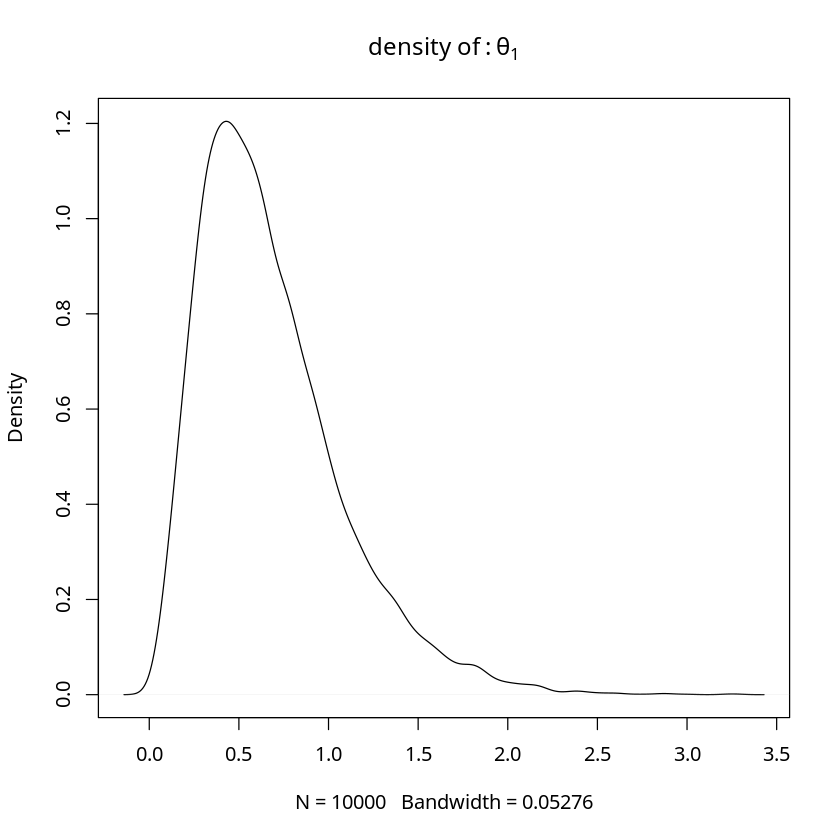

In [407]:
plot(density(g[,1]), main=expression("density of": theta[1]))

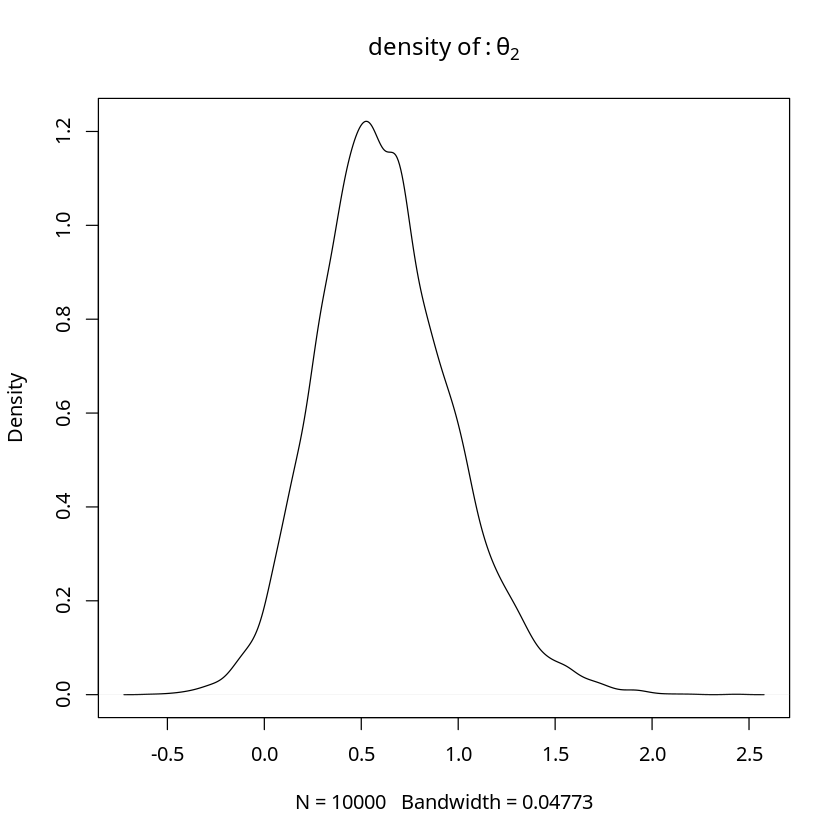

In [408]:
plot(density(g[,2]), main=expression("density of": theta[2]))

### determine the posterior mean, median, variance and 95% CI for each parameter:

In [409]:
print(summary(g))

       V1                V2         
 Min.   :0.01737   Min.   :-0.5806  
 1st Qu.:0.38649   1st Qu.: 0.3899  
 Median :0.59792   Median : 0.5985  
 Mean   :0.67694   Mean   : 0.6248  
 3rd Qu.:0.88215   3rd Qu.: 0.8383  
 Max.   :3.27109   Max.   : 2.4341  


In [410]:
print(list(var(g[,1]),var(g[,2])))

[[1]]
[1] 0.1574302

[[2]]
[1] 0.1205897



In [411]:
# theta 1
quantile(g[,1],probs=c(.025,.975))

2.5%     97.5% 
0.1385429 1.6637739

In [412]:
# theta 2
quantile(g[,2],probs=c(.025,.975))

2.5%      97.5% 
0.02008881 1.37627338

### Plot the first 100 in sequence to inspect movement:


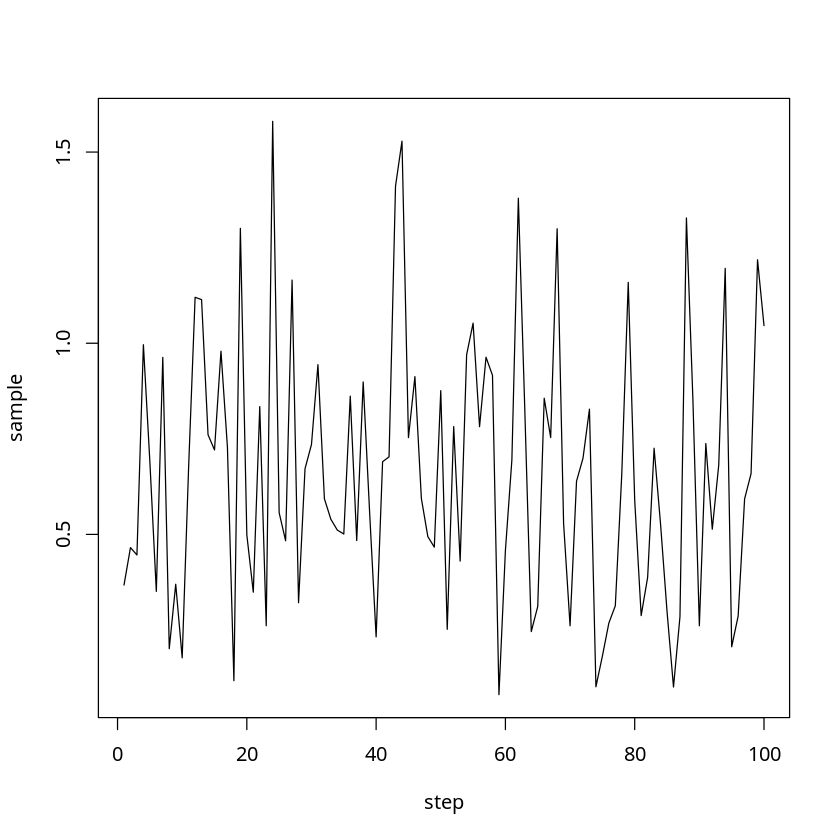

In [413]:
# plot theta1 first:
plot(g[,1][1:100], type="l",xlab="step",ylab="sample")

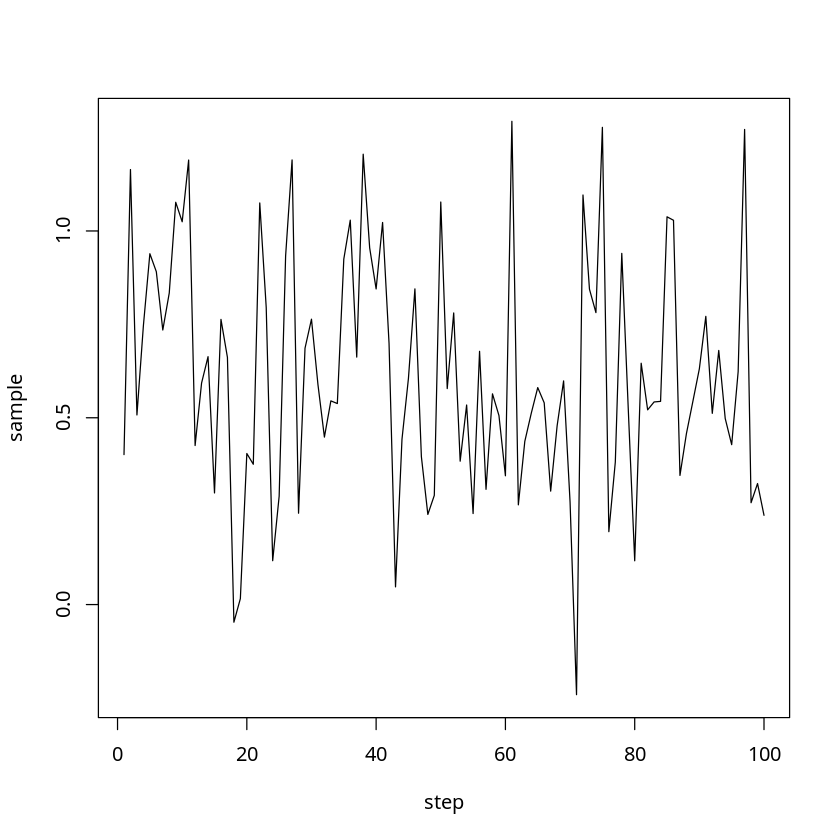

In [414]:
# plot theta1 first:
plot(g[,2][1:100], type="l",xlab="step",ylab="sample")

## Problem 2:
- use Gibbs sampling to sample from the posterior distributions of $\lambda$, $\phi$, and $k$. 

We have that 
$$\lambda|y,k \sim gamma(\sum_{i=1}^k y_i+4, k+1)$$
$$\phi|y,k \sim gamma(\sum_{i=k+1}^{112}y_i, 112-k+2)$$
$$ p(k|y,\phi,\theta)=\frac{\exp(k(\phi-\theta))(\theta/\phi)^{\sum^ky_i}}{\sum_{k=1}^{112}\exp(k(\phi-\theta))(\theta/\phi)^{\sum^ky_i}}  $$

In [934]:
# lets get the ysum vector:
df = read.table("coal.txt",header = TRUE)
x =as.numeric(df$disasters)
ysum = cumsum(x)


In [935]:
kprob = function(k,lambda,phi,ks){
    denom = sum(exp(ks*(phi-lambda))*(lambda/phi)^(ysum[ks]))
    num = exp(k*(phi-lambda))*(lambda/phi)^ysum[k]
    return(num/denom)
}

In [936]:
# first we sample for lambda: theta[1,2,3] = lambda, phi, k
gibbs2 = function(B){
    ks = 1:112
    thetapost=matrix(0, nrow=B,ncol=3)
    theta=c(2,3,40)
    
    for (i in 1:B){
        # insert alternative conditional sampling:
        theta[1] = rgamma(1, ysum[theta[3]]+4, theta[3]+1)
        theta[2] = rgamma(1, ysum[112]-ysum[theta[3]],112-theta[3]+2)
         
        p = kprob((1:112),theta[1],theta[2],ks)
        theta[3] = sample(ks,1, replace = TRUE, prob = p)
        
        thetapost[i,] = theta
    }
    return(thetapost)

}


In [937]:
samp = gibbs2(10000)

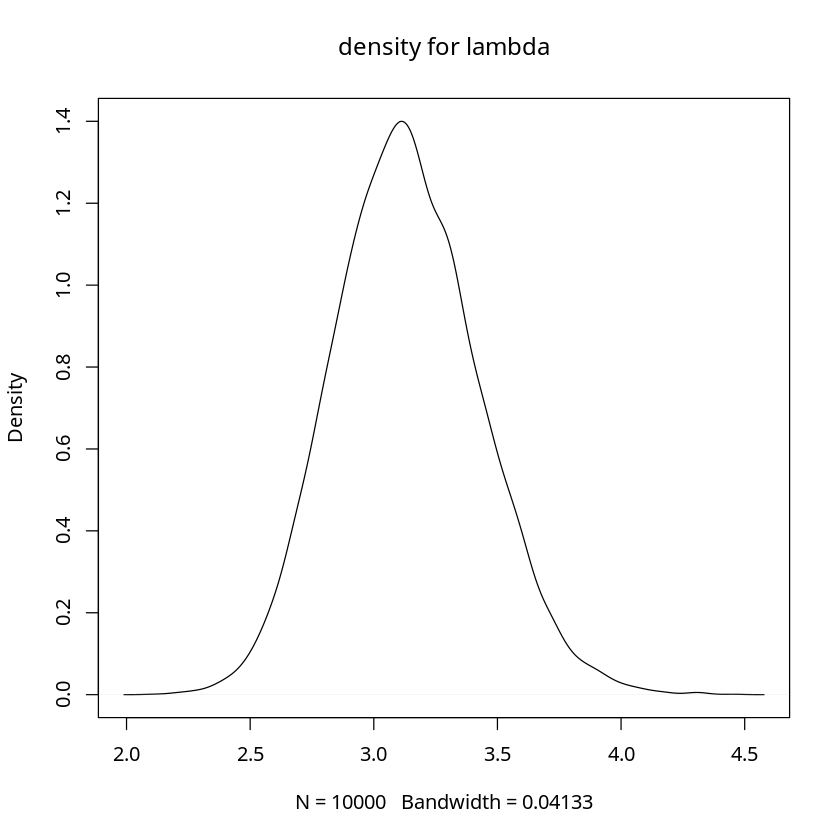

In [938]:
plot(density(samp[,1]),main=expression("density for lambda"))

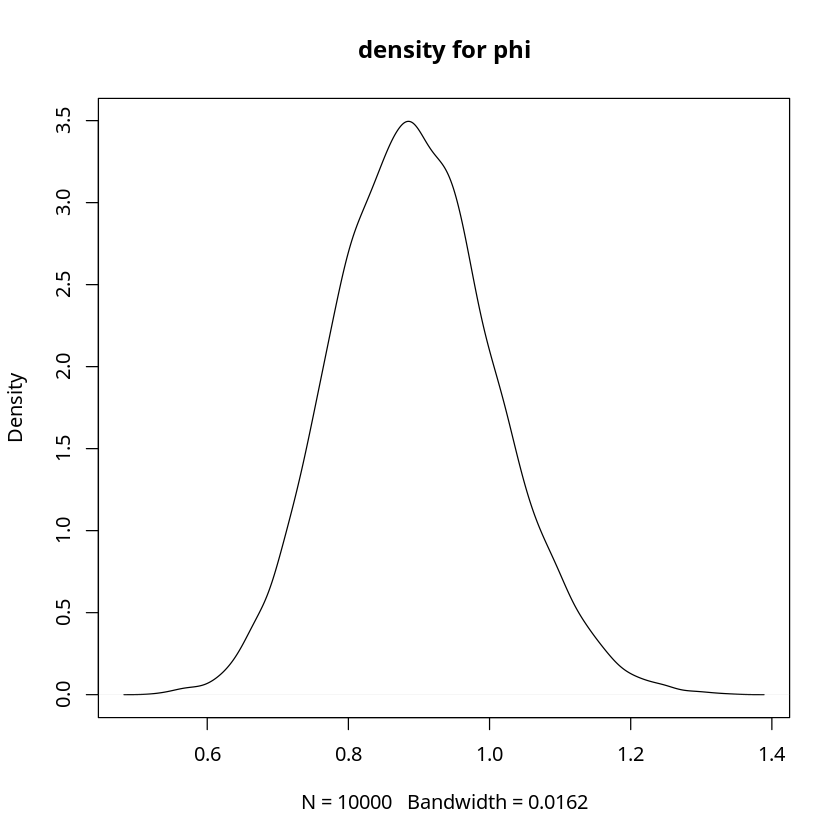

In [939]:
plot(density(samp[,2]),main="density for phi")

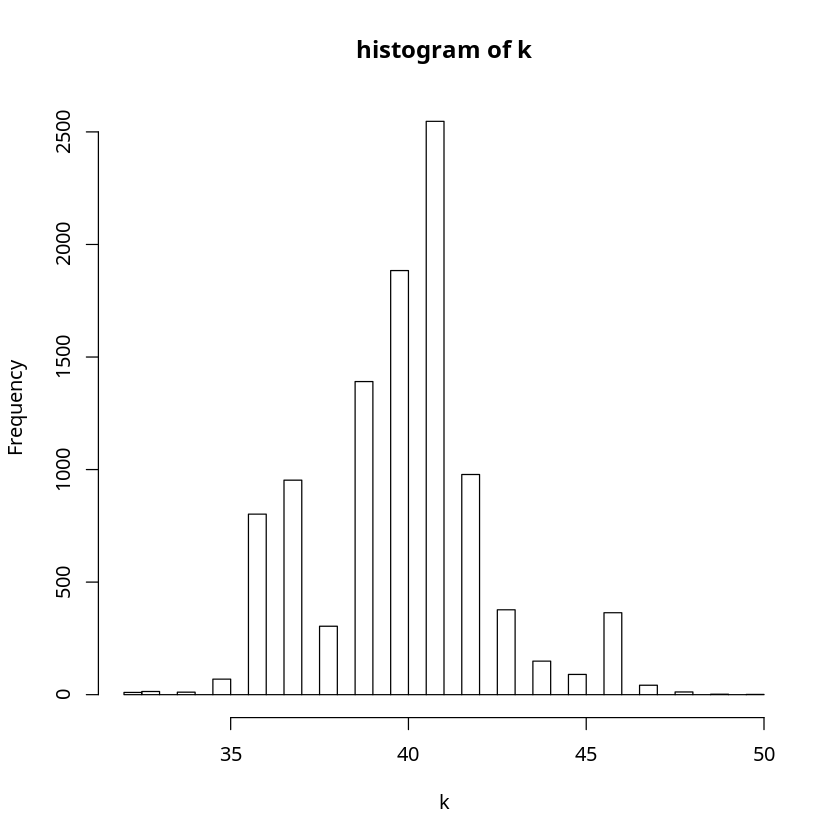

In [940]:
hist(samp[,3], breaks = 30, main="histogram of k",xlab="k")

### Determine the posterior mean, median, variance, and 95% CI for each:


In [941]:
# mean 
summary(samp)

       V1              V2               V3       
 Min.   :2.114   Min.   :0.5307   Min.   :32.00  
 1st Qu.:2.935   1st Qu.:0.8148   1st Qu.:39.00  
 Median :3.123   Median :0.8912   Median :40.00  
 Mean   :3.135   Mean   :0.8951   Mean   :40.06  
 3rd Qu.:3.323   3rd Qu.:0.9684   3rd Qu.:41.00  
 Max.   :4.454   Max.   :1.3403   Max.   :50.00  

In [942]:
# get median for plot later
med = median(samp[,3])

In [943]:
var(samp)

0.08499501,0.00194839,-0.19951066
0.00194839,0.01289225,-0.06219989
-0.19951066,-0.06219989,5.81074978


In [944]:
#lambda
quantile(samp[,1],probs=c(.025,.975))

2.5%    97.5% 
2.598544 3.727591

In [945]:
#phi
quantile(samp[,2],probs=c(.025,.975))

2.5%     97.5% 
0.6853733 1.1303862

In [946]:
#k
quantile(samp[,3],probs=c(.025,.975))

2.5% 97.5% 
   36    46

### Make a plot of the original data with the median of the full conditional of k

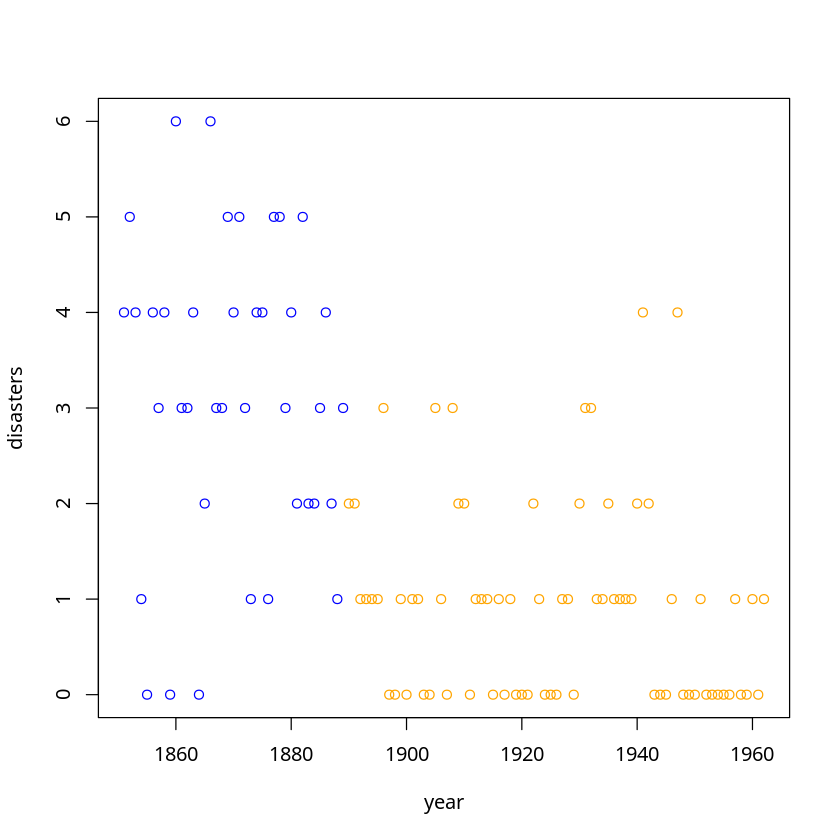

In [947]:
plot(df,col=ifelse(1:nrow(df)<med, "blue", "orange"))


## Problem 3:
- assume the target is Inverse-Gamma(27,73.08). Use the unnormalized run 3 Metropolis-Hasting chains with B=10000 at three different initial conditions 1,3,5. Use a N(m,.5^2) jumping distribution. 

In [948]:
B = 10000


In [949]:
unIG = function(theta){ theta^(-28)*exp(-73.08/theta)}

In [950]:
cmh = function(B, start) {

  theta = matrix(0, nrow = B + 1, ncol = length(start))
  theta[1] = start

  for (i in 2:(B + 1)) {
    # sample from the Jump distribution
    jumptheta = rnorm(1,2.61,.5)
      
    #print(unIG(theta[i-1]))
    num.r = log(unIG(jumptheta))
    den.r = log(unIG(theta[i-1]))
    r <- num.r - den.r
    #print(r)
    if (log(runif(1)) <= min(r, 0)) {
      theta[i] <- jumptheta
    } else {
      theta[i] <- theta[i - 1]
    }
  }
  # return half
  return(theta[floor(B/2):length(theta)])
}


### a. Trace Plots:
- do the trace plots suggest convergence?

In [951]:
one=cmh(B,1)
three=cmh(B,3)
five=cmh(B,5)


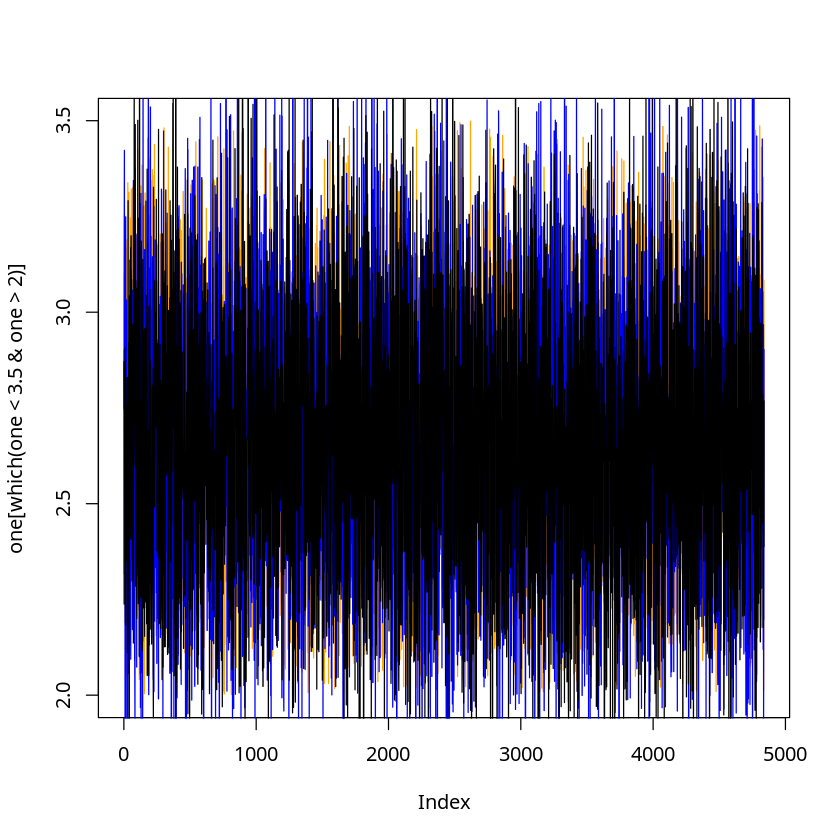

In [952]:
plot(one[which(one<3.5 & one>2.0)], type="l",col="orange")
lines(three[which(one<3.5 & one>2.0)], col="blue")
lines(five[which(one<3.5 & one>2.0)], col="black")


In [434]:
var(one)

[1] 0.1223251

In [435]:
var(three)

[1] 0.1210773

In [436]:
var(five)

[1] 0.1224024

### b. autocorrelation plots:

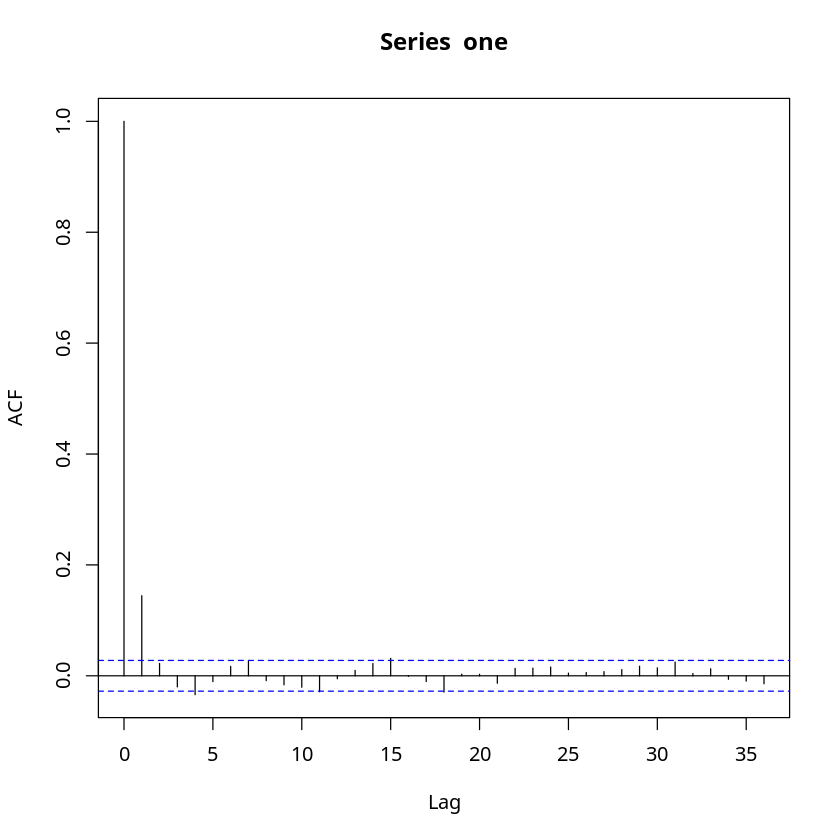

In [953]:
plot(acf(one))

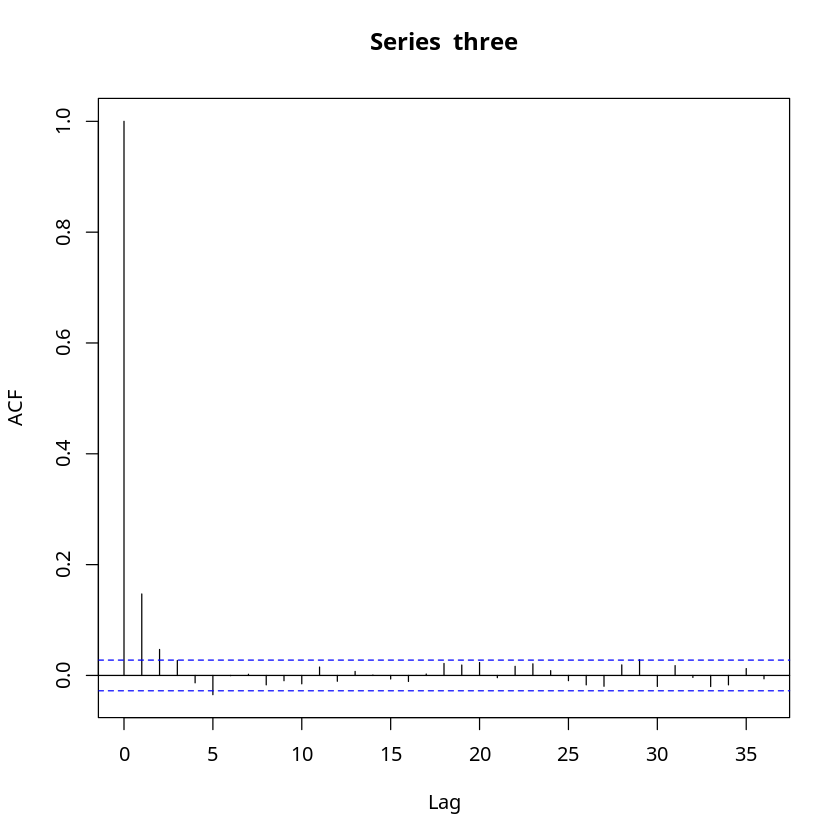

In [954]:
plot(acf(three))

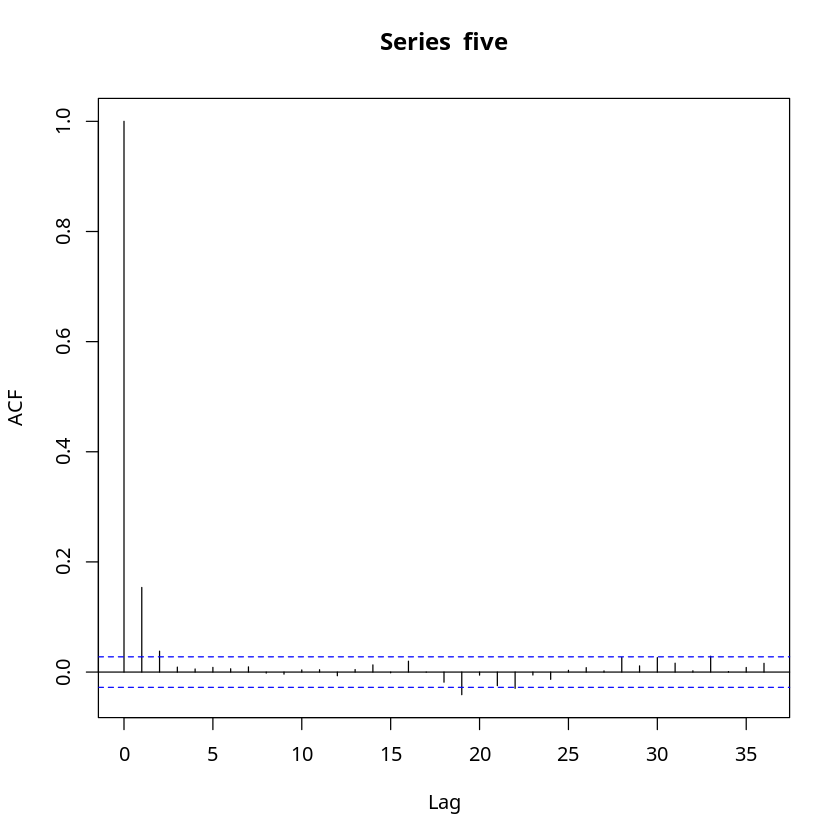

In [955]:
plot(acf(five))

### c. Effective Size

In [956]:
library(coda)


In [957]:
effectiveSize(one)
effectiveSize(three)
effectiveSize(five)
length(one)

var1 
4137.293

var1 
3795.194

var1 
3669.218

[1] 5002

### d. Gelman-Rubin Statistic:
- have they converged?

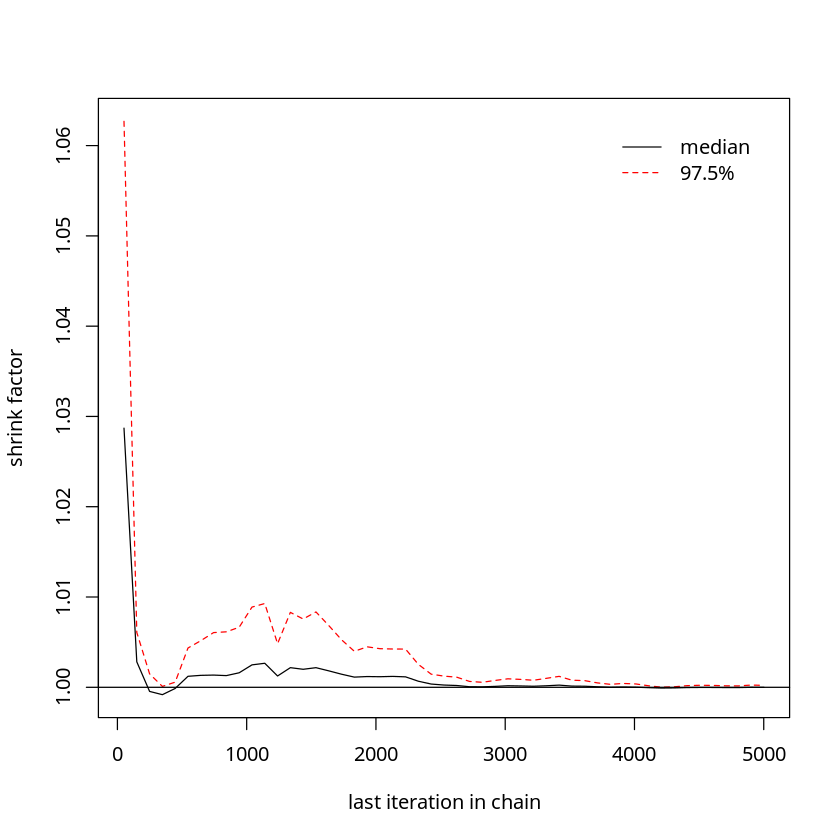

In [442]:
# Plot Gelman statistic
mc = mcmc.list(mcmc(one),mcmc(three),mcmc(five))
gelman.plot(mc, autoburnin = FALSE)

In [443]:
gelman.diag(mc)

Potential scale reduction factors:

     Point est. Upper C.I.
[1,]          1          1


### e. Plot Densities:

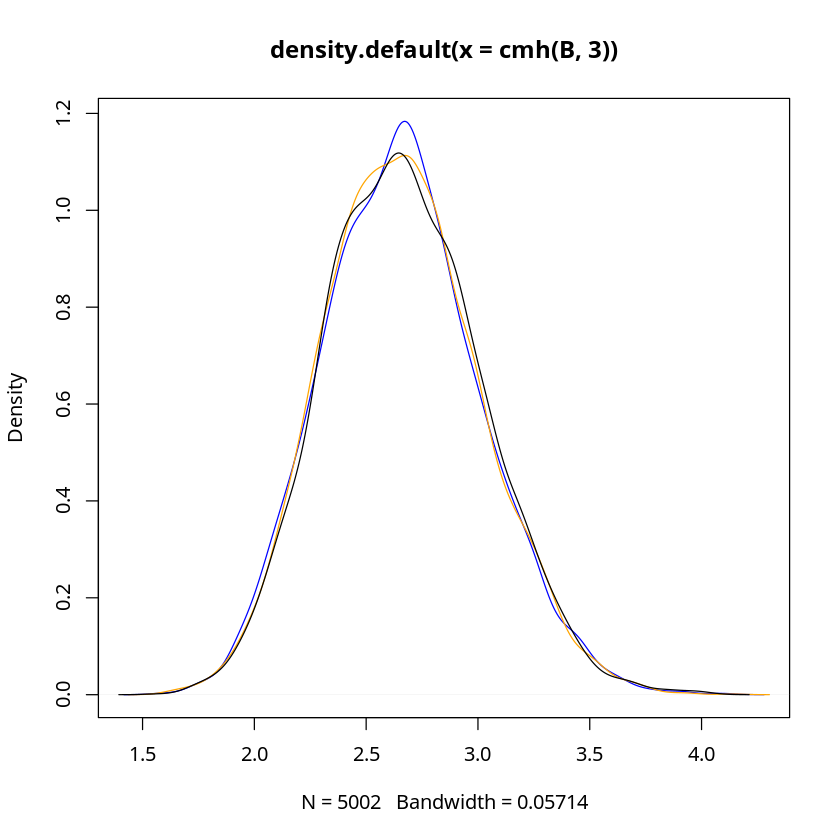

In [444]:
# justplotting the three different distributions for different initial conditions. 
plot(density(cmh(B,3)),col="blue")
lines(density(cmh(B,1)),col="orange", main="three initial starting values")
lines(density(cmh(B,5)))

### f. Empirical Density combining all three:

In [445]:
new = c(one,three,five)

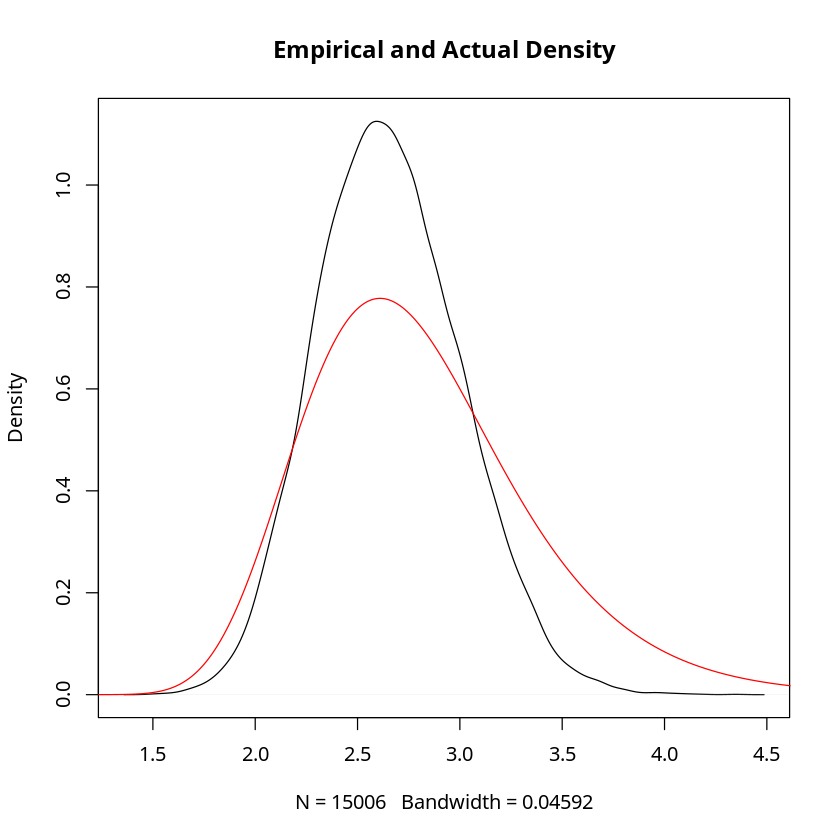

In [446]:
# plot the emipirical and actual on top
theta = seq(1,6,length.out=length(new))
qtarget <- function(theta){
    73.08^27/gamma(27)*(theta)^(-28)*exp(-73.08/theta)
}

plot(density(new), main="Empirical and Actual Density")
lines(theta,qtarget(theta), col="red")

## Problem 4:
- same as problem 3 but let the sample we take from J be centered at current value for theta


In [449]:
cmh4 = function(B, start) {

  theta = matrix(0, nrow = B + 1, ncol = length(start))
  theta[1] = start

  for (i in 2:(B + 1)) {
    # sample from the Jump distribution
    jumptheta = rnorm(1,theta[i-1],.5)
      
    #print(unIG(theta[i-1]))
    num.r = log(unIG(jumptheta))
    den.r = log(unIG(theta[i-1]))
    r <- num.r - den.r
    #print(r)
    if (log(runif(1)) <= min(r, 0)) {
      theta[i] <- jumptheta
    } else {
      theta[i] <- theta[i - 1]
    }
  }
  # return half
  return(theta[floor(B/2):length(theta)])
}

### a. Trace Plots:


In [450]:
one=cmh4(B,1)
three=cmh4(B,3)
five=cmh4(B,5)


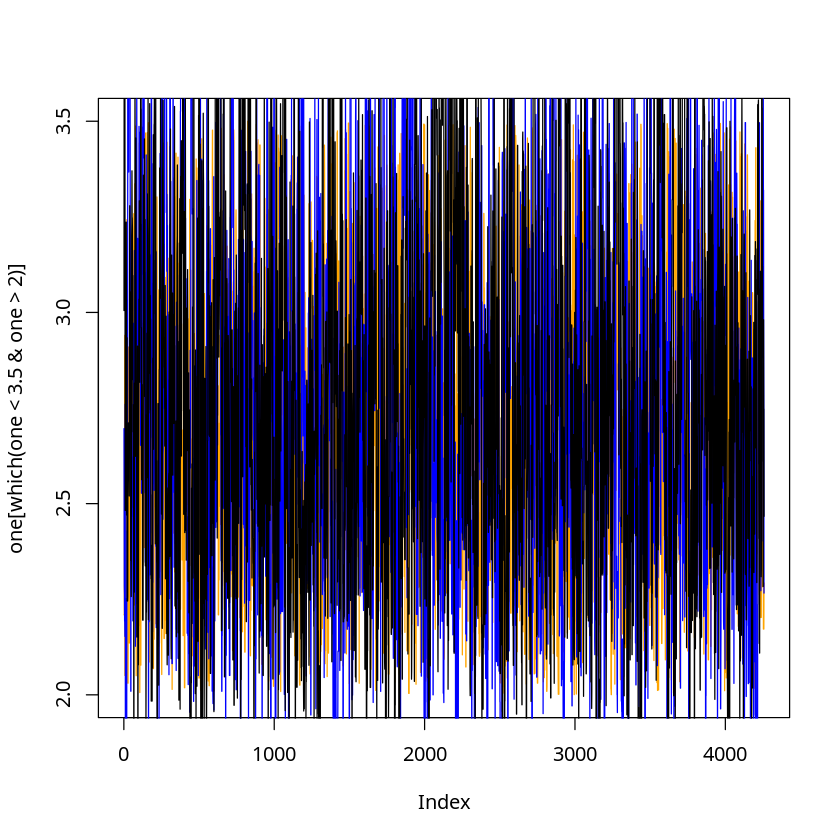

In [451]:
plot(one[which(one<3.5 & one>2.0)], type="l",col="orange")
lines(three[which(one<3.5 & one>2.0)], col="blue")
lines(five[which(one<3.5 & one>2.0)], col="black")



In [452]:
var(one)
var(three)
var(five)

[1] 0.2848682

[1] 0.332072

[1] 0.3132907

## b. Autocorrelation Plots:


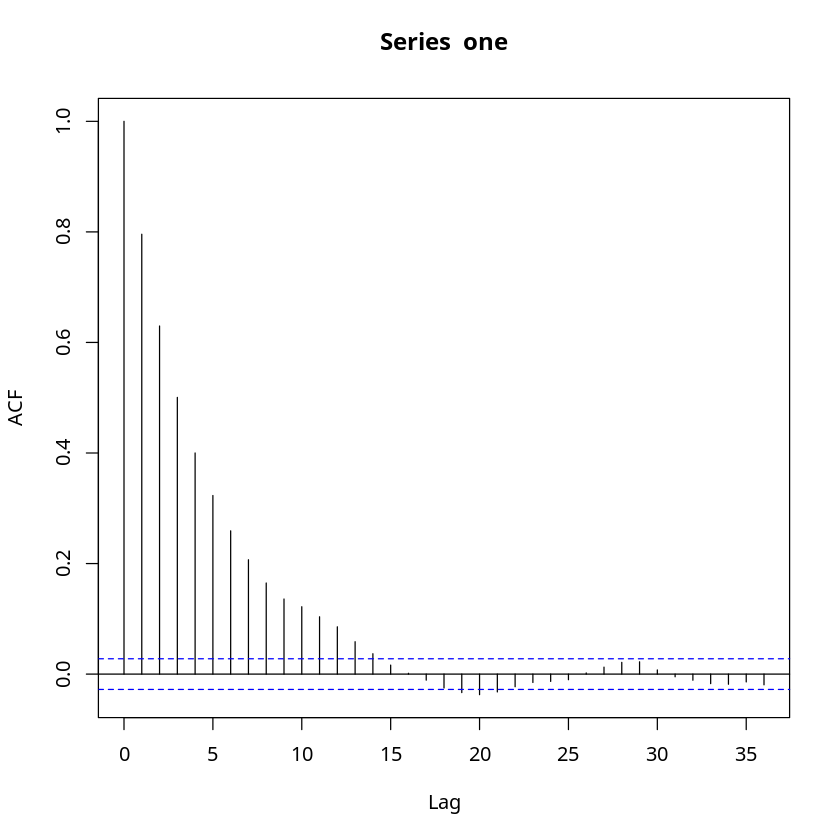

In [453]:
plot(acf(one))

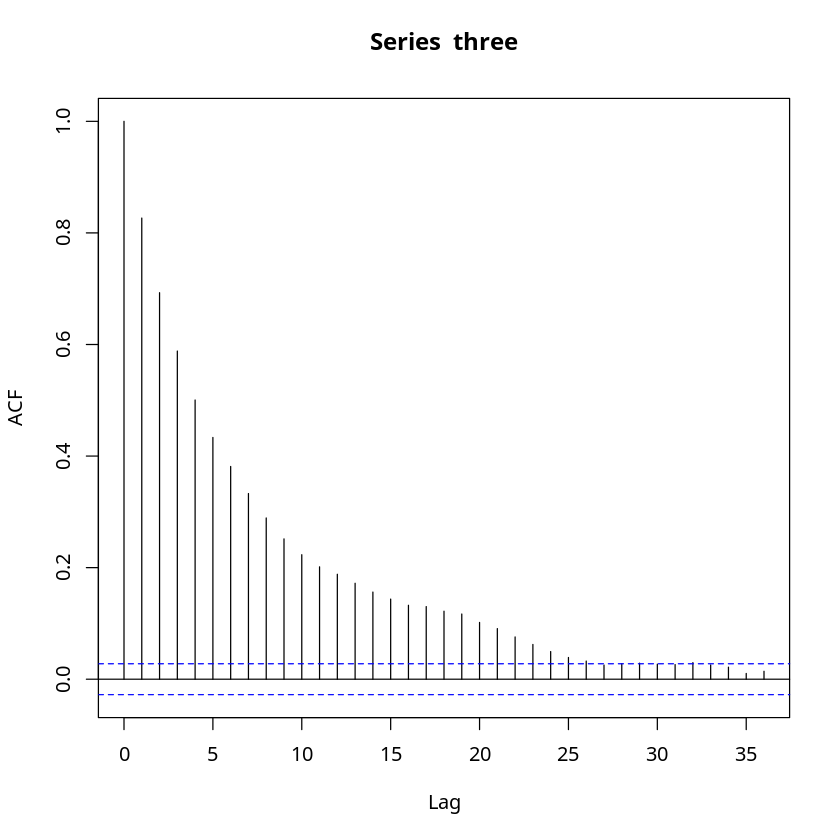

In [454]:
plot(acf(three))

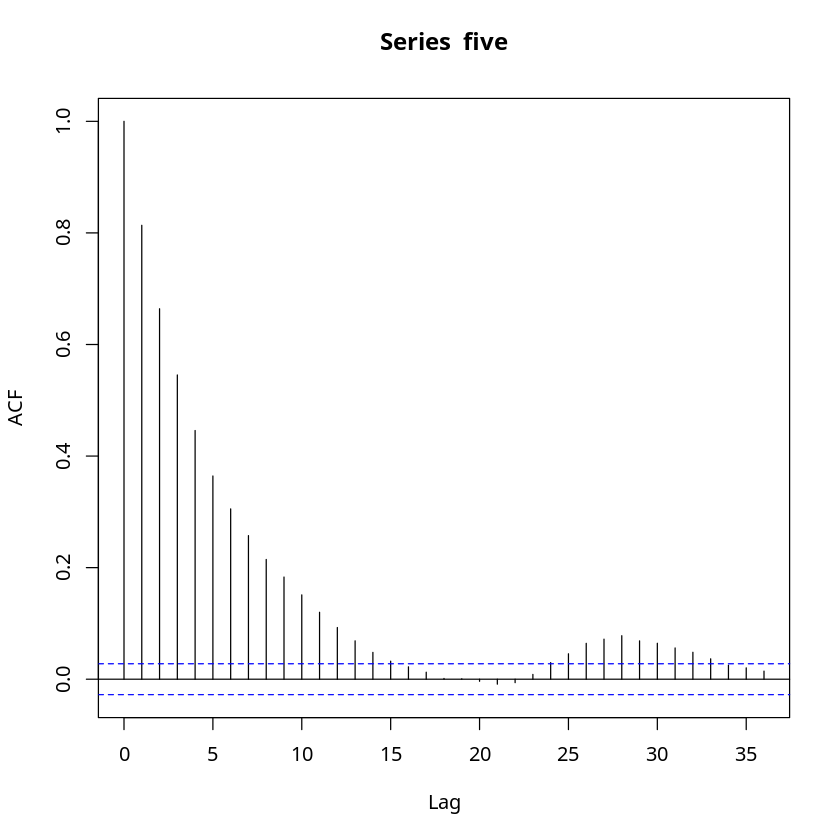

In [455]:
plot(acf(five))

In [456]:
effectiveSize(one)
effectiveSize(three)
effectiveSize(five)
length(one)

var1 
568.907

var1 
425.1103

var1 
513.9998

[1] 5002

### d. Gelman-Rubin Diagnostic:
- have they converged?

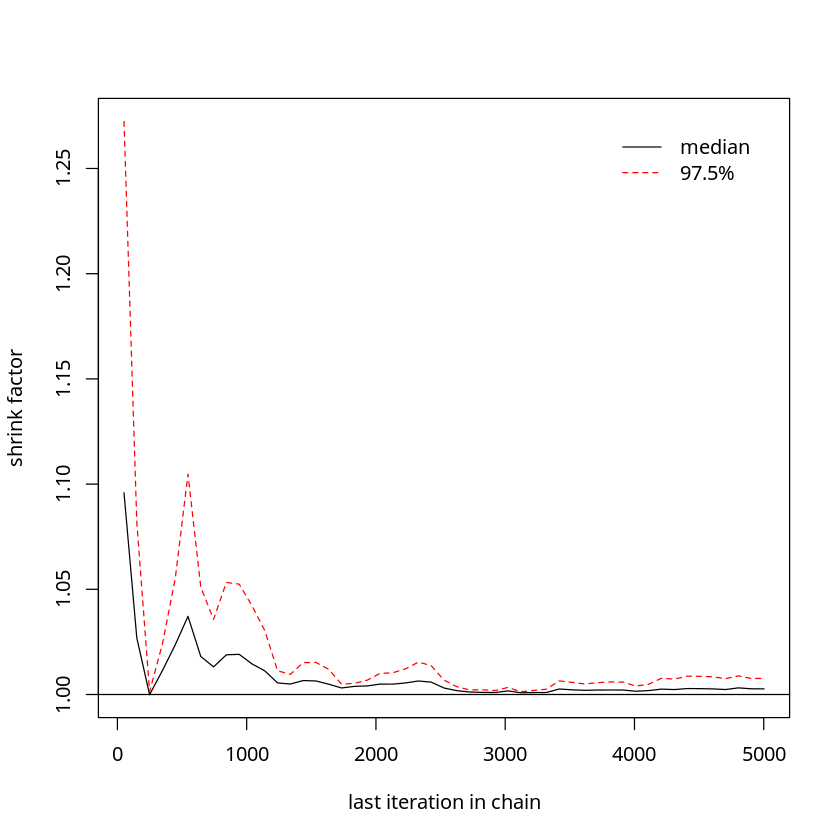

In [457]:
# Plot Gelman statistic
mc = mcmc.list(mcmc(one),mcmc(three),mcmc(five))
gelman.plot(mc, autoburnin = FALSE)

### e. Draw three densities:

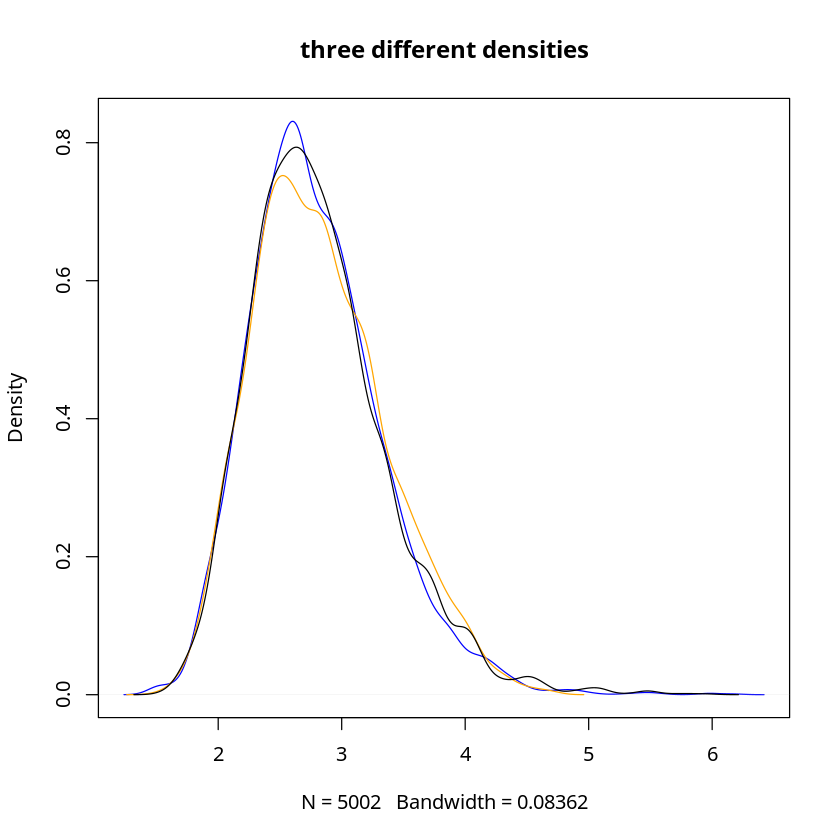

In [459]:
# justplotting the three different distributions for different initial conditions. 
plot(density(cmh4(B,3)),col="blue", main="three different densities")
lines(density(cmh4(B,1)),col="orange", main="three initial starting values")
lines(density(cmh4(B,5)))

### f.  Empirical and Actual Density

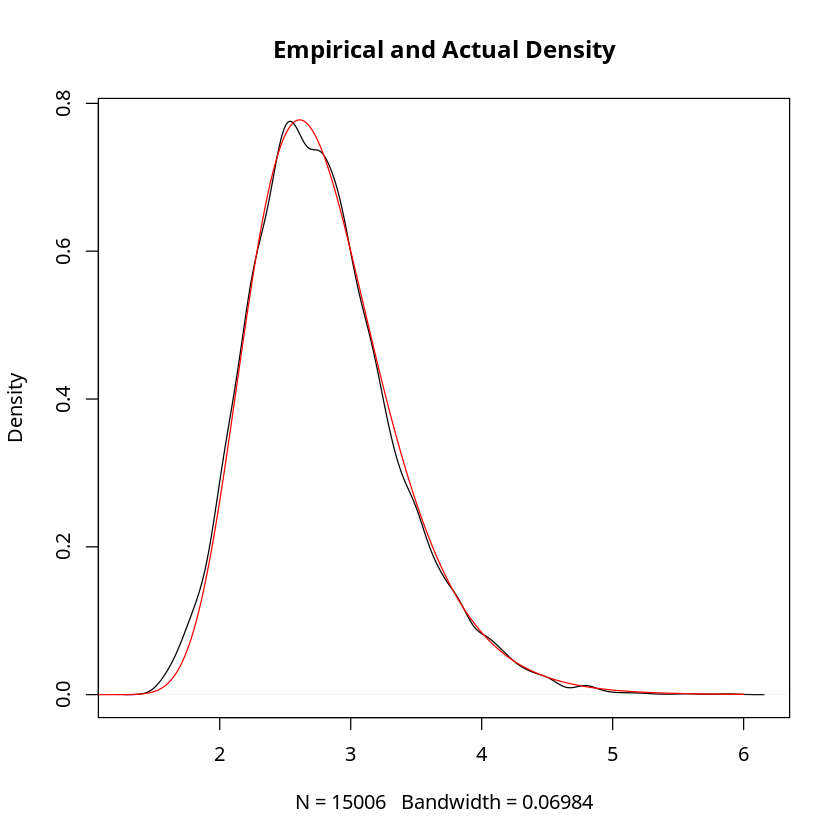

In [461]:
# plot the emipirical and actual on top
new = c(one,three,five)
theta = seq(1,6,length.out=length(new))
qtarget <- function(theta){
    73.08^27/gamma(27)*(theta)^(-28)*exp(-73.08/theta)
}

plot(density(new), main="Empirical and Actual Density")
lines(theta,qtarget(theta), col="red")

## Problem 5:
- find a new jumping distribution that will perform better than the previous two. Better performance can be as simple as an increase in the effective sample size and better autocorrelation plots. 

- First thing, try to center the jumping between the mode and current theta


In [910]:
rdtcl= function(n, df){
    (rt(n, df)*sqrt(.4)+2.61 )
}
cmh5 = function(B, start) {

  theta = matrix(0, nrow = B + 1, ncol = length(start))
  theta[1] = start

  for (i in 2:(B + 1)) {
    # sample from the Jump distribution
    jumptheta = rnorm(1,(theta[i-1]+2.61)/2,1)
    #jumptheta =  (theta[i-1]+rdtcl(1,20))/2
    #print(unIG(theta[i-1]))
    
    #jumptheta =1/rgamma(1,27,73.08) 
    while (jumptheta<=0){jumptheta = rnorm(1,(theta[i-1]+2.61)/2,1)}
    num.r = log(unIG(jumptheta))
    den.r = log(unIG(theta[i-1]))
    r <- num.r - den.r
    
    if (log(runif(1)) <= min(r, 0)) {
      theta[i] <- jumptheta
    } else {
      theta[i] <- theta[i - 1]
    }
  }
  # return half
  return(theta[floor(B/2):length(theta)])
}

In [911]:
B=10000
one=cmh5(B,1)
three=cmh5(B,3)
five=cmh5(B,5)



### a. Trace Plots

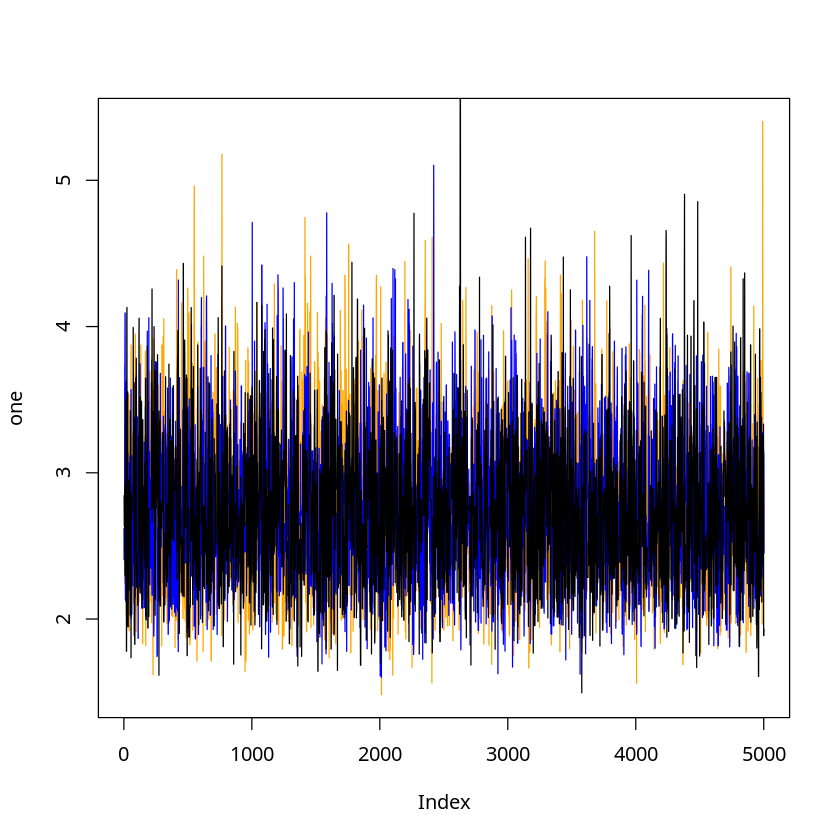

In [912]:
plot(one, type="l",col="orange")
lines(three, col="blue")
lines(five, col="black")



In [913]:
var(one)
var(three)
var(five)

[1] 0.2332304

[1] 0.2196664

[1] 0.2340786

### b. Autocorrelation Plots

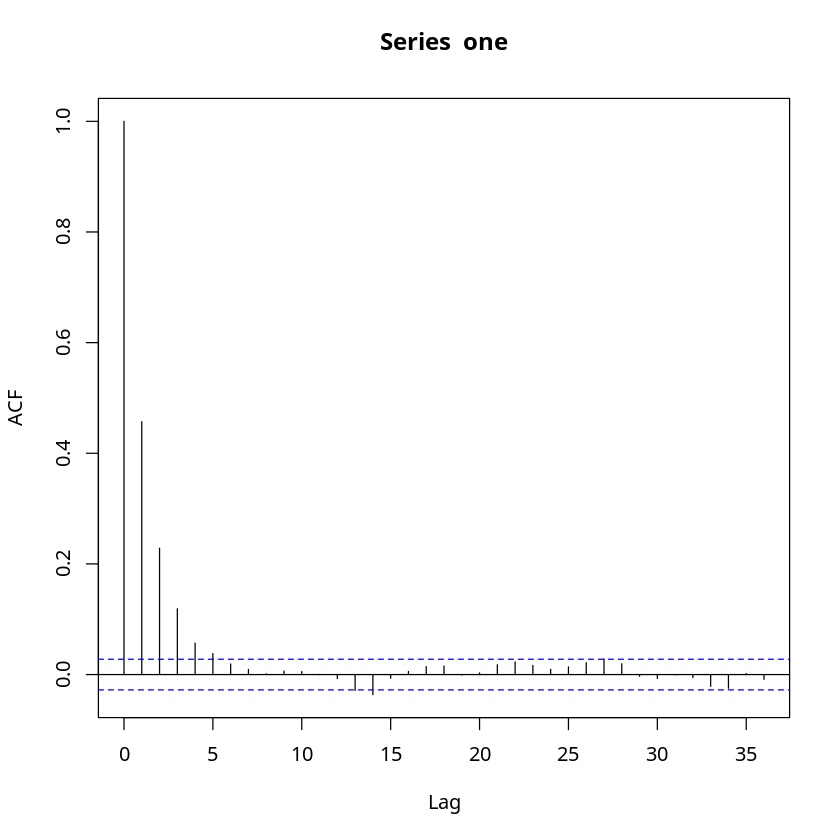

In [914]:
plot(acf(one))

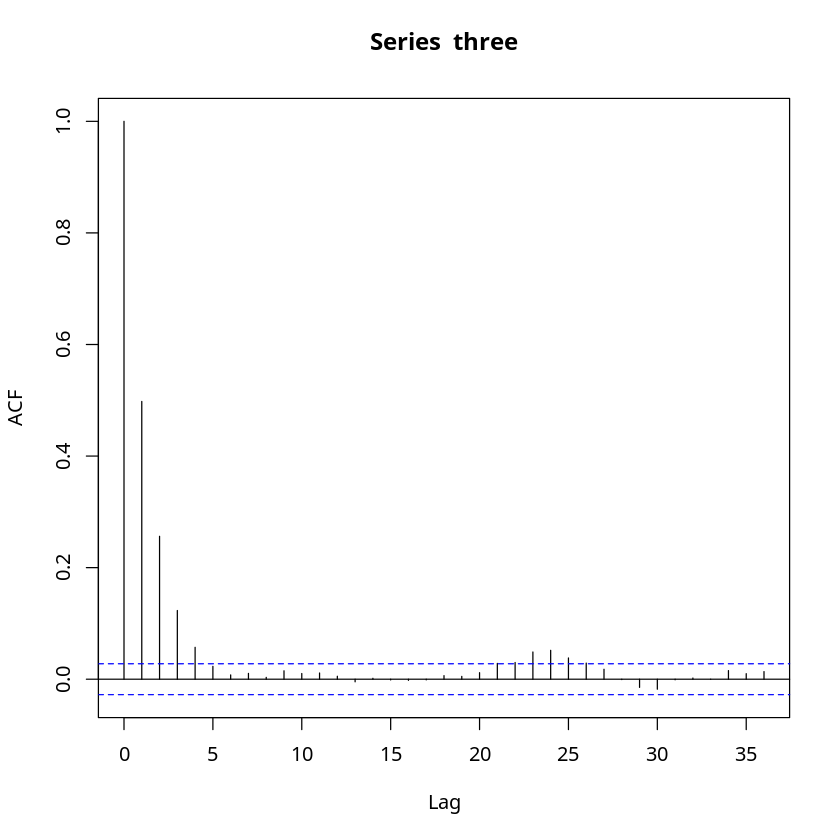

In [915]:
plot(acf(three))

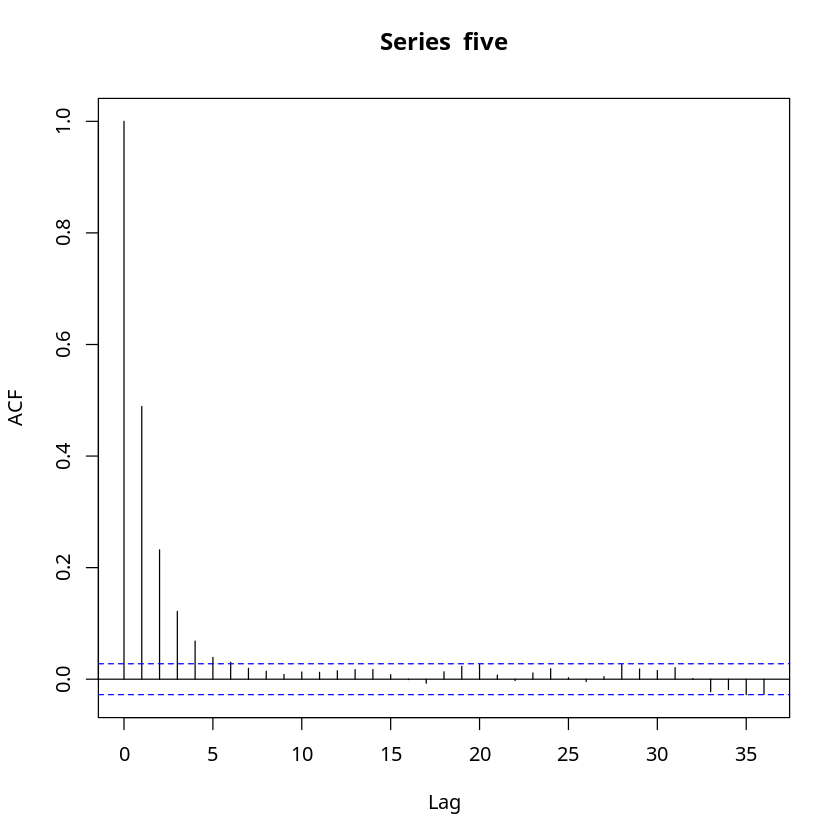

In [916]:
plot(acf(five))

### c. Effective Sample Size

In [917]:
effectiveSize(one)
effectiveSize(three)
effectiveSize(five)
length(one)

var1 
1773.119

var1 
1676.497

var1 
1717.213

[1] 5002

### d. Gelman-Rubin Diagnostics

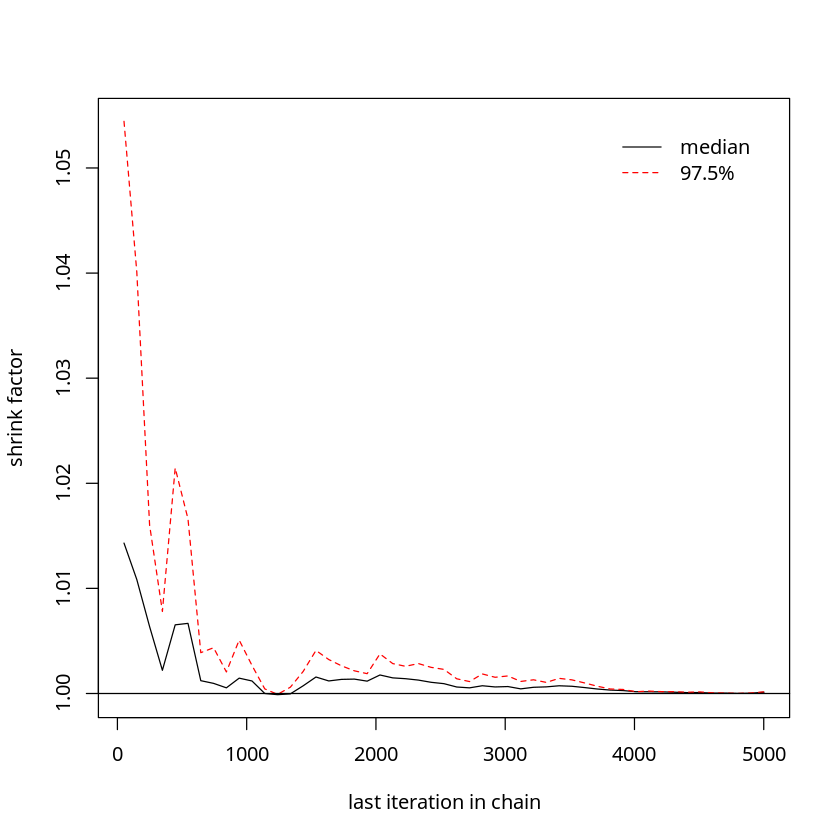

In [918]:
# Plot Gelman statistic
mc = mcmc.list(mcmc(one),mcmc(three),mcmc(five))
gelman.plot(mc, autoburnin = FALSE)

### e. Separate Density Plots

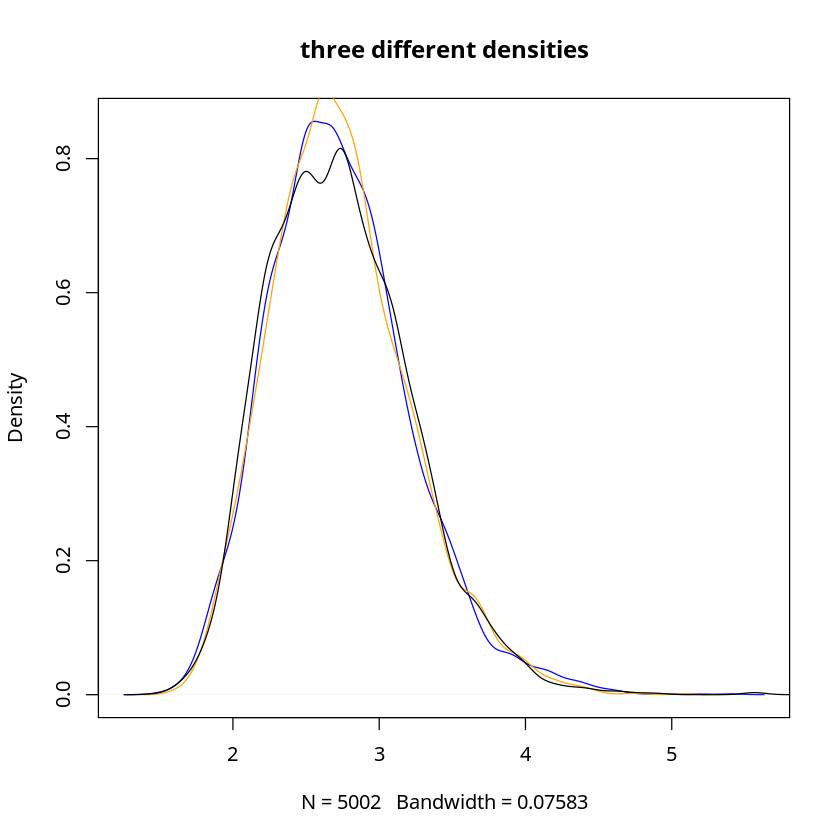

In [919]:
# justplotting the three different distributions for different initial conditions. 

plot(density(one),col="blue", main="three different densities")
lines(density(three),col="orange", main="three initial starting values")
lines(density(five))

### f. Empirical and Actual Plot

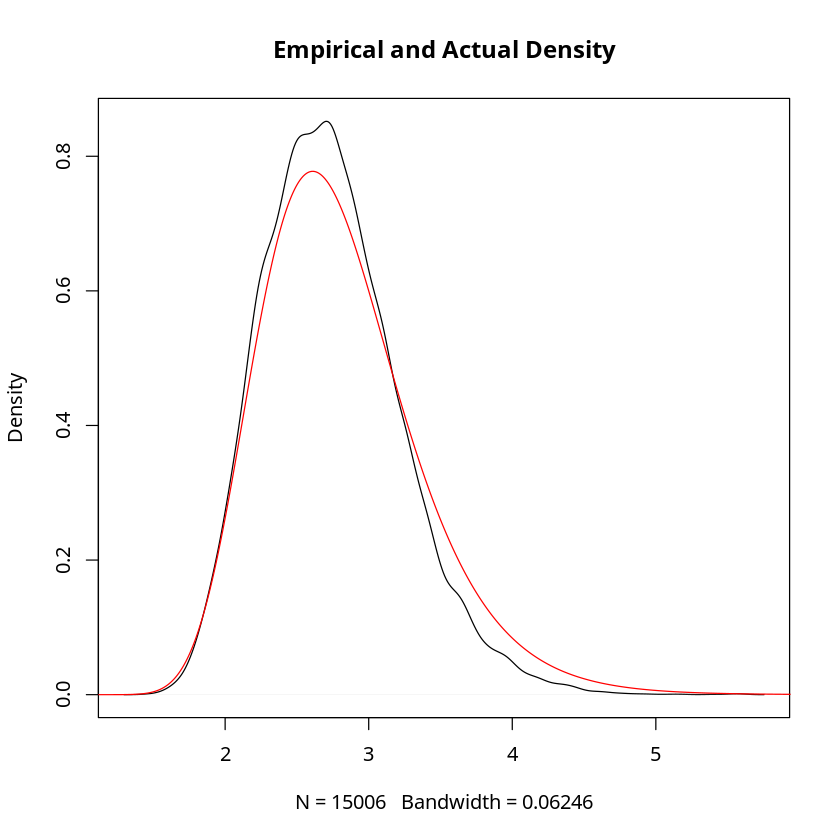

In [920]:
# plot the emipirical and actual on top
new = c(one,three,five)
theta = seq(1,6,length.out=length(new))
qtarget <- function(theta){
    73.08^27/gamma(27)*(theta)^(-28)*exp(-73.08/theta)
}

plot(density(new), main="Empirical and Actual Density")
lines(theta,qtarget(theta), col="red")
#lines(theta,dnorm(theta,2.61,.5), col="orange")
#lines(theta,dtcl(theta,2.61,.4,2))

I should have built the Hasting-Metropolis Algorithm for non-symmetric Jump distributions and use the actual posterior itself. That would have worked perfectly. It is kind of cheating though because in the real world we would not know our true posterior distribution. Perhaps it would have still helped to implement the non-symmetric version of the algorithm and used a non-symmetric distribution after inspecting the posterior itself is non-symmetric. Problem 3 and 4 give some insight that the posterior is non-symmetric and this may suggest that a class of right skewed distributions would have been better at scanning the parameter space. 